In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain

import skimage
from skimage import io

import scipy.stats


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
21433,00005712_028.png,Infiltration,28,5712,33,M,AP,2500,2048,0.168,0.168,NaN
111628,00030570_002.png,Edema|Infiltration,2,30570,29,F,AP,3056,2544,0.139,0.139,NaN
49813,00012628_017.png,Atelectasis,17,12628,51,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
356,00001912_002.png,No Finding,2,1912,055Y,F,PA,2992,2991,0.143,0.143
1340,00006992_000.png,No Finding,0,6992,073Y,F,PA,2048,2500,0.171,0.171
777,00004082_011.png,No Finding,11,4082,055Y,F,PA,2992,2991,0.143,0.143


Add image paths to `sample_df` since we will use this dataframe to analyze pixel-level data

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', sample_df.shape[0])
sample_df['path'] = sample_df['Image Index'].map(all_image_paths.get)
sample_df.sample(3)

Scans found: 112120 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
622,00003191_001.png,Pneumothorax,1,3191,058Y,F,PA,1855,2021,0.194308,0.194308,/data/images_002/images/00003191_001.png
1641,00008522_025.png,No Finding,25,8522,061Y,F,AP,2500,2048,0.168000,0.168000,/data/images_004/images/00008522_025.png
4147,00020398_002.png,Edema|Infiltration,2,20398,021Y,F,AP,3056,2544,0.139000,0.139000,/data/images_009/images/00020398_002.png


Inpect data and make any necessary cleanup steps

In [5]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


The `Unnamed: 11` column only contains a Null value. Hence, drop it

In [6]:
df_xray_clean = all_xray_df.drop('Unnamed: 11', axis=1)

In [7]:
df_xray_clean.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


Inspect statistics of the data

In [8]:
df_xray_clean.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800


There seems to be an error when entering Patient Age data where there are multiple records where the Patient Age exceed 400.

Hence, we will perform EDA only records with the 'Patient Age' <= 100

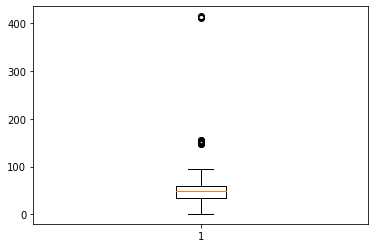

In [9]:
plt.boxplot(df_xray_clean['Patient Age']);

In [10]:
df_xray_clean = df_xray_clean[df_xray_clean['Patient Age'] <= 100]

One-Hot Encoding labels to ease the EDA process

In [11]:
## Here I'm just going to split up my "Finding Labels" column so that I have one column in my dataframe
# per disease, with a binary flag. This makes EDA a lot easier! 

all_labels = np.unique(list(chain(*df_xray_clean['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [12]:
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df_xray_clean[c_label] = df_xray_clean['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df_xray_clean.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
3321,00000877_015.png,No Finding,15,877,39,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9755,00002524_034.png,No Finding,34,2524,59,M,PA,2524,3056,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
79913,00019637_004.png,Nodule|Pneumothorax,4,19637,72,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [13]:
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5150,00027415_077.png,Atelectasis|Effusion|Mass,77,27415,023Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1093,00005722_004.png,No Finding,4,5722,032Y,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2467,00012378_000.png,Cardiomegaly|Effusion,0,12378,063Y,M,PA,2990,2948,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are 1,430 X-ray images in this dataset with 'Pneumonia' in its label which is account for around 1.275% of all records in this dataset

In [16]:
df_xray_clean['Pneumonia'].sum(), df_xray_clean['Pneumonia'].mean()

(1430.0, 0.012756012274316705)

#### EDA: The patient demographic data such as gender, age, patient position,etc. (as it is available)


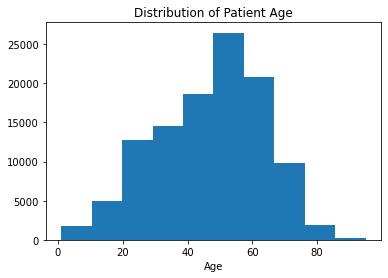

In [17]:
plt.hist(df_xray_clean['Patient Age']);
plt.title('Distribution of Patient Age');
plt.xlabel('Age');

In [18]:
df_xray_clean['Patient Age'].describe()

count    112104.000000
mean         46.872574
std          16.598152
min           1.000000
25%          35.000000
50%          49.000000
75%          59.000000
max          95.000000
Name: Patient Age, dtype: float64

In [19]:
df_xray_clean['Patient Age'].mode()[0]

58

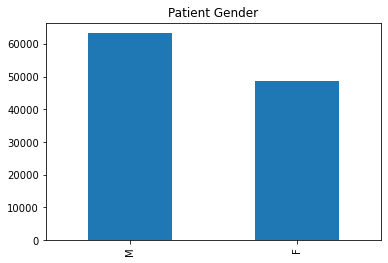

In [20]:
# Gender
df_xray_clean['Patient Gender'].value_counts().plot(kind="bar");
plt.title('Patient Gender');

In [21]:
df_xray_clean['Patient Gender'].value_counts() / df_xray_clean.shape[0]

M    0.564904
F    0.435096
Name: Patient Gender, dtype: float64

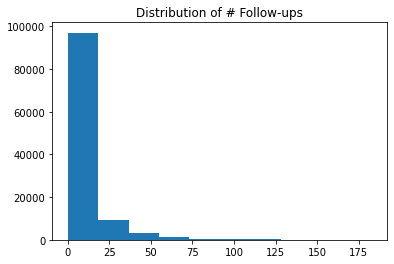

In [22]:
# Follow up Number
plt.hist(df_xray_clean['Follow-up #']);
plt.title('Distribution of # Follow-ups');

In [23]:
df_xray_clean['Follow-up #'].describe()

count    112104.000000
mean          8.574172
std          15.406734
min           0.000000
25%           0.000000
50%           3.000000
75%          10.000000
max         183.000000
Name: Follow-up #, dtype: float64

#### EDA: The x-ray views taken (i.e. view position)


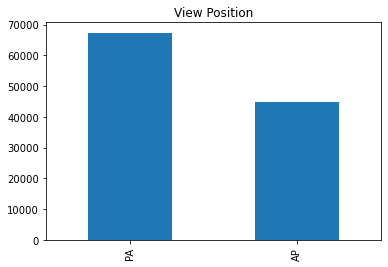

In [24]:
# View Position
df_xray_clean['View Position'].value_counts().plot(kind="bar");
plt.title('View Position');

In [31]:
df_xray_clean['View Position'].value_counts()/df_xray_clean.shape[0]

PA    0.600326
AP    0.399674
Name: View Position, dtype: float64

####  The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases

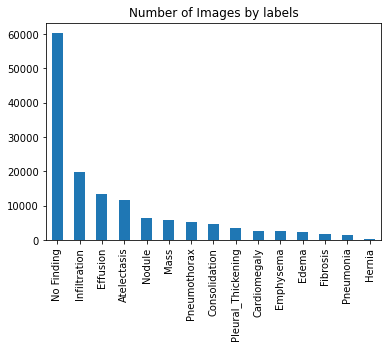

In [32]:
# First, find a distribution of each label first
ax = df_xray_clean[all_labels].sum().sort_values(ascending=False).plot(kind='bar');
ax.set(title = 'Number of Images by labels');

In [33]:
print("Number of No Finding cases: {} ({:4f}%)".format(int(df_xray_clean['No Finding'].sum()), 100*df_xray_clean['No Finding'].mean()))

Number of No Finding cases: 60353 (53.836616%)


In [34]:
df_xray_no_finding = df_xray_clean[df_xray_clean['No Finding'] == 1]

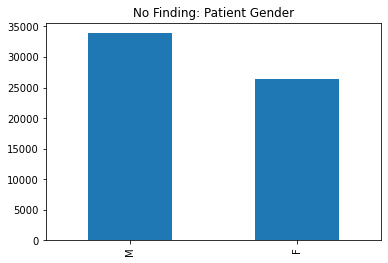

In [35]:

df_xray_no_finding['Patient Gender'].value_counts().plot(kind="bar");
plt.title('No Finding: Patient Gender');

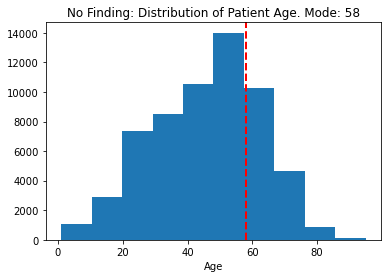

In [36]:
plt.hist(df_xray_no_finding['Patient Age']);

mode_val = df_xray_no_finding['Patient Age'].mode()[0]
plt.title('No Finding: Distribution of Patient Age. Mode: {}'.format(mode_val));
plt.xlabel('Age');
plt.axvline(mode_val, color='r', linestyle='dashed', linewidth=2);

In [37]:
# Follow up Number
df_xray_no_finding['Follow-up #'].describe()

count    60353.000000
mean         6.061389
std         12.380528
min          0.000000
25%          0.000000
50%          2.000000
75%          6.000000
max        181.000000
Name: Follow-up #, dtype: float64

Around 54% of data do not have any findings

In [38]:
df_xray_with_labels = df_xray_clean[df_xray_clean['No Finding'] == 0]
df_xray_with_labels.shape

(51751, 26)

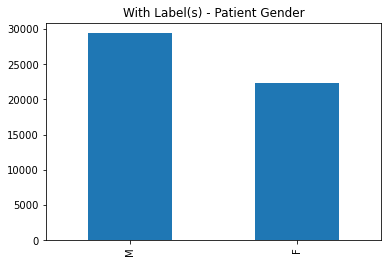

In [39]:
df_xray_with_labels['Patient Gender'].value_counts().plot(kind="bar");
plt.title('With Label(s) - Patient Gender');

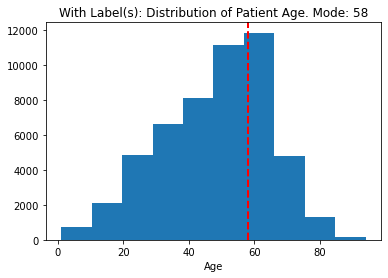

In [40]:
plt.hist(df_xray_with_labels['Patient Age']);

mode_val = df_xray_with_labels['Patient Age'].mode()[0]
plt.title('With Label(s): Distribution of Patient Age. Mode: {}'.format(mode_val));
plt.xlabel('Age');
plt.axvline(mode_val, color='r', linestyle='dashed', linewidth=2);

In [41]:
# Follow up Number
df_xray_with_labels['Follow-up #'].describe()

count    51751.000000
mean        11.504628
std         17.874232
min          0.000000
25%          1.000000
50%          5.000000
75%         14.000000
max        183.000000
Name: Follow-up #, dtype: float64

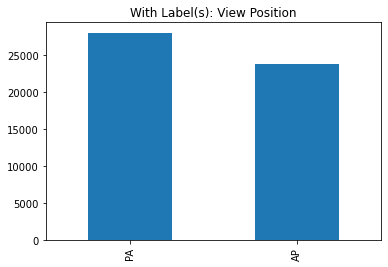

In [42]:
# View Position
df_xray_with_labels['View Position'].value_counts().plot(kind="bar");
plt.title('With Label(s): View Position');

In [43]:
# Number of Pneumonia
numPneumonia = int(df_xray_clean['Pneumonia'].sum())
ratePneumonia = 100*df_xray_clean['Pneumonia'].mean()
print('Number of Pneumonia cases: {} ({:.4f}%)'.format(numPneumonia, ratePneumonia))
print('Number of non-Pneumonia cases: {} ({:.4f}%)'.format(df_xray_clean.shape[0] - numPneumonia, 100 - ratePneumonia))


Number of Pneumonia cases: 1430 (1.2756%)
Number of non-Pneumonia cases: 110674 (98.7244%)


Next, we will find statistics only for those cases that are not 'No Finding'


In [44]:
# Number of Pneumonia
numPneumonia = int(df_xray_with_labels['Pneumonia'].sum())
ratePneumonia = 100*df_xray_with_labels['Pneumonia'].mean()
print('With Label(s) - Number of Pneumonia cases: {} ({:.4f}%)'.format(numPneumonia, ratePneumonia))
print('With Label(s) - Number of non-Pneumonia cases: {} ({:.4f}%)'.format(df_xray_with_labels.shape[0] - numPneumonia, 100 - ratePneumonia))


With Label(s) - Number of Pneumonia cases: 1430 (2.7632%)
With Label(s) - Number of non-Pneumonia cases: 50321 (97.2368%)


#### EDA: The distribution of other diseases that are comorbid with pneumonia


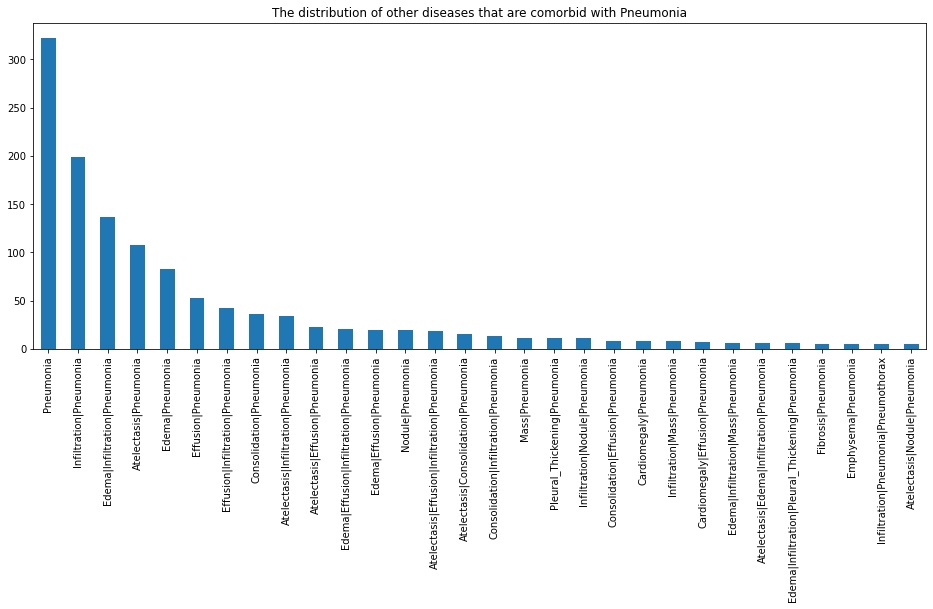

In [55]:
##Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
df_xray_clean[df_xray_clean.Pneumonia==1]['Finding Labels'].value_counts()[:30].plot(kind='bar');
plt.title('The distribution of other diseases that are comorbid with Pneumonia');

#### EDA: Number of disease per patient 


In [48]:
# We will find statistics of disease per patient only for those cases that are not 'No Finding'
df_xray_with_labels['Num_Diseases'] = df_xray_with_labels[all_labels].sum(axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [49]:
df_xray_with_labels['Num_Diseases'].describe()

count    51751.000000
mean         1.568356
std          0.827965
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          9.000000
Name: Num_Diseases, dtype: float64

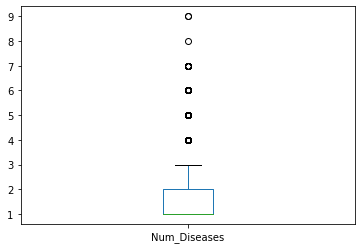

In [50]:
df_xray_with_labels['Num_Diseases'].plot(kind='box');

In [53]:
df_xray_with_labels[df_xray_with_labels['Pneumonia'] == 1]['Num_Diseases'].describe()

count    1430.000000
mean        2.332867
std         1.051360
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         9.000000
Name: Num_Diseases, dtype: float64

In [54]:
df_xray_pneumonia = df_xray_with_labels[df_xray_with_labels['Pneumonia'] == 1]
df_xray_pneumonia_only = df_xray_pneumonia[df_xray_pneumonia['Num_Diseases'] == 1]

22.5% of X-ray images with Pneumonia only labeled as Pneumonia 

In [58]:
df_xray_pneumonia_only.shape[0], df_xray_pneumonia_only.shape[0]/df_xray_pneumonia.shape[0]

(322, 0.22517482517482518)

199 X-ray images with Pneumonia (13.9%) are labeled with "Infiltration"

In [62]:
df_xray_pneumonia_infiltration = df_xray_pneumonia[df_xray_pneumonia['Finding Labels'] == 'Infiltration|Pneumonia']
df_xray_pneumonia_infiltration.shape[0], df_xray_pneumonia_infiltration.shape[0]/df_xray_pneumonia.shape[0]


(199, 0.13916083916083916)

137 X-ray images with Pneumonia (9.6%) are labeled with "Edema" and "Infiltration"

In [63]:
df_xray_pneumonia_edema_infiltration = df_xray_pneumonia[df_xray_pneumonia['Finding Labels'] == 'Edema|Infiltration|Pneumonia']
df_xray_pneumonia_edema_infiltration.shape[0], df_xray_pneumonia_edema_infiltration.shape[0]/df_xray_pneumonia.shape[0]


(137, 0.0958041958041958)

108 X-ray images with Pneumonia (7.6%) are labeled with "Atelectasis"

In [65]:
df_xray_pneumonia_atelectasis = df_xray_pneumonia[df_xray_pneumonia['Finding Labels'] == 'Atelectasis|Pneumonia']
df_xray_pneumonia_atelectasis.shape[0], df_xray_pneumonia_atelectasis.shape[0]/df_xray_pneumonia.shape[0]


(108, 0.07552447552447553)

### Other EDA for Pneumonia

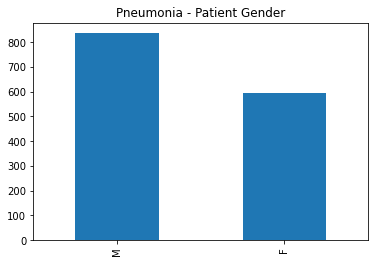

In [118]:
df_xray_pneumonia['Patient Gender'].value_counts().plot(kind="bar");
plt.title('All Pneumonia - Patient Gender');

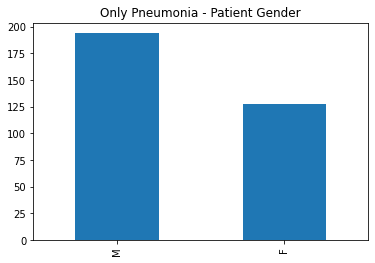

In [122]:
df_xray_pneumonia_only['Patient Gender'].value_counts().plot(kind="bar");
plt.title('Only Pneumonia - Patient Gender');

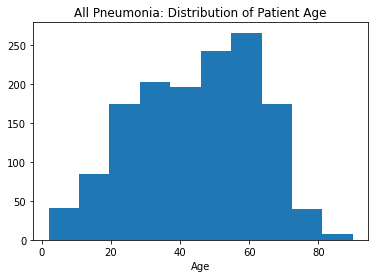

In [134]:
plt.hist(df_xray_pneumonia['Patient Age']);
plt.title('All Pneumonia: Distribution of Patient Age');
plt.xlabel('Age');


In [132]:
df_xray_pneumonia['Patient Age'].describe()

count    1430.000000
mean       44.670629
std        17.639098
min         2.000000
25%        31.000000
50%        46.000000
75%        59.000000
max        90.000000
Name: Patient Age, dtype: float64

In [138]:
df_xray_pneumonia['Patient Age'].mode()[0]

33

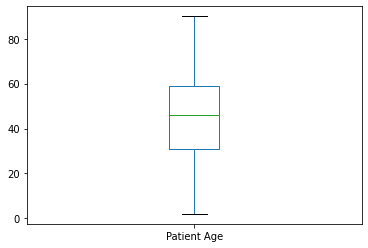

In [139]:
df_xray_pneumonia['Patient Age'].plot(kind="box")

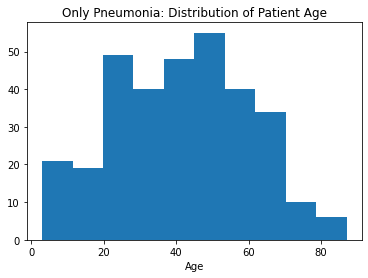

In [135]:
plt.hist(df_xray_pneumonia_only['Patient Age']);
plt.title('Only Pneumonia: Distribution of Patient Age');
plt.xlabel('Age');

In [125]:
# Follow up Number
df_xray_pneumonia['Follow-up #'].describe()

count    1430.000000
mean       14.439161
std        20.078227
min         0.000000
25%         2.000000
50%         7.000000
75%        18.000000
max       155.000000
Name: Follow-up #, dtype: float64

In [126]:
df_xray_pneumonia_only['Follow-up #'].describe()

count    322.000000
mean      11.031056
std       16.561007
min        0.000000
25%        1.000000
50%        4.000000
75%       14.000000
max      102.000000
Name: Follow-up #, dtype: float64

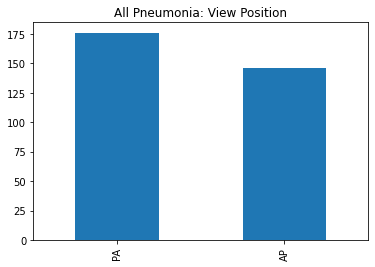

In [154]:
# View Position
df_xray_pneumonia_only['View Position'].value_counts().plot(kind="bar");
plt.title('All Pneumonia: View Position');

### Summary of EDA

The dataset contains patients that are either 'healthy' (x-ray labeled as 'No Finding') and have at least one disease specified in the 'Finding Labels' column

The dataset contains around 56% and 44% of male and female patients, respectively and the 54% of all patients are healthy.

Out of all patients with at least one disease (46%), there are 1430 Pneumonia cases which is account for around 3%. The data also shows that Pneumonia
* often comorbid with the following diseases
  * Infiltration
  * Atelectasis
  * Effusion
  * Edema
* Mostly found in patients with the age range from 30 to 60

In addition, the data also shows that patients with at least one disease have more number of follow-ups that a healthy patient



### EDA: Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.


Inspect x-ray images of healthy patients

In [140]:
df_sample_healthy = sample_df[sample_df['No Finding'] == 1]
df_sample_healthy.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12,00000080_005.png,No Finding,5,80,067Y,F,PA,1884,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


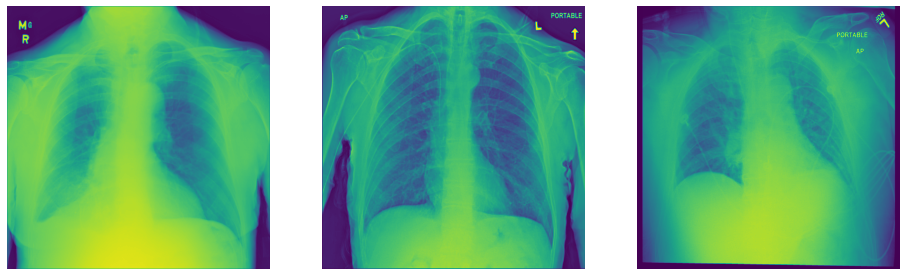

In [32]:
plt.figure(figsize=(16,6))

for cnt in range(3):
    ax=plt.subplot(1, 3, cnt+1)
    ax.imshow(io.imread(df_sample_healthy['path'].iloc[cnt]));
    ax.set_axis_off()



Inspect x-ray images of patients with Pneumonia

In [33]:
df_sample_pneumonia = sample_df[sample_df['Pneumonia'] == 1]
df_sample_pneumonia.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
256,00001373_010.png,Cardiomegaly|Effusion|Pneumonia,10,1373,058Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
287,00001529_004.png,Consolidation|Infiltration|Pneumonia,4,1529,054Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
382,00001993_000.png,Infiltration|Nodule|Pneumonia,0,1993,011Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
723,00003789_000.png,Nodule|Pneumonia,0,3789,041Y,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
775,00004074_000.png,Mass|Nodule|Pneumonia,0,4074,047Y,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


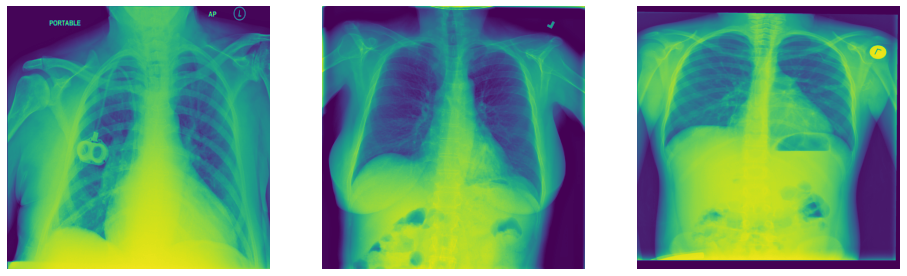

In [34]:
plt.figure(figsize=(16,6))

for cnt in range(3):
    ax=plt.subplot(1, 3, cnt+1)
    ax.imshow(io.imread(df_sample_pneumonia['path'].iloc[cnt]));
    ax.set_axis_off()

Inspect the intensities of an x-ray image of a healthy patient and a patient with pneumonia to find a threshold to mask an image to remove background

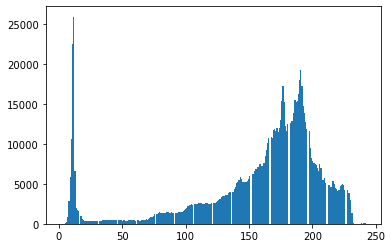

In [141]:
img_healthy = io.imread(df_sample_healthy['path'].iloc[0])
x = plt.hist(img_healthy.ravel(),bins=256)

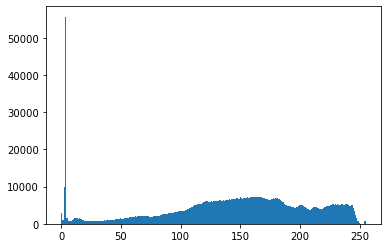

In [142]:
img_pneunomia = io.imread(df_sample_pneumonia['path'].iloc[0])
x = plt.hist(img_pneunomia.ravel(),bins=256)

Try applying a mask to ensure that the chest area is masked properly

In [143]:
thresh = 25

img_healthy_bin = (img_healthy > thresh) * 255
img_pneunomia_bin = (img_pneunomia > thresh) * 255

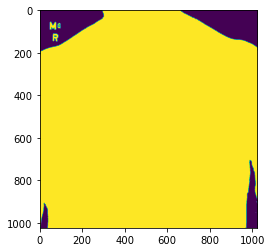

In [146]:
plt.imshow(img_healthy_bin);

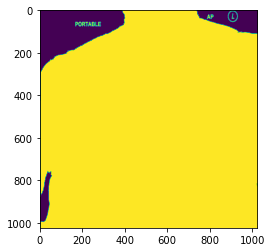

In [148]:
plt.imshow(img_pneunomia_bin);

In [149]:
def plot_intensities(df):
    '''
    Function to plot a histogram of intensities x-ray images
    in the input data frame.
    Note that only 20 images will be used in this plot to save the computation time
    '''
    intensities = []
    for img_path in df['path'][:20]: 

        img = io.imread(img_path)
        img_mask = (img > thresh) & (img < 250)
        intensities.extend(img[img_mask].tolist())
        
    plt.hist(intensities, bins=256);
    
    mode_val = scipy.stats.mode(intensities)[0][0]
    plt.title('Mode of intensities: {}'.format(mode_val))
    plt.axvline(mode_val, color='r', linestyle='dashed', linewidth=2)
    
    return intensities

### Healthy Patients

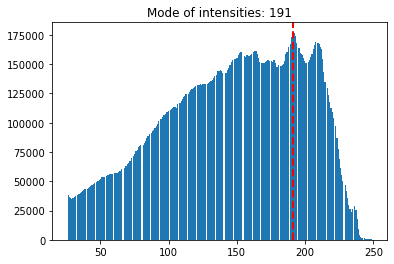

In [68]:
plot_intensities(df_sample_healthy);

### Patients with Pneumonia

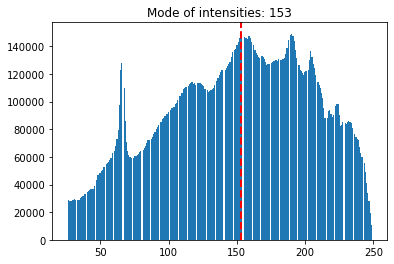

In [69]:
plot_intensities(df_sample_pneumonia);

### Patients with Infiltration

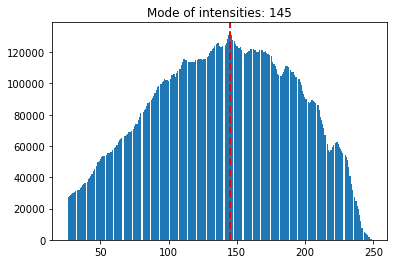

In [70]:
df_sample_Infiltration = sample_df[sample_df.Infiltration == 1]

plot_intensities(df_sample_Infiltration);

### Patients with Effusion

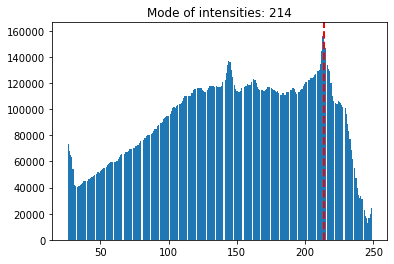

In [150]:
df_sample_Effusion = sample_df[sample_df.Effusion == 1]

plot_intensities(df_sample_Effusion);

### Patients with Atelectasis

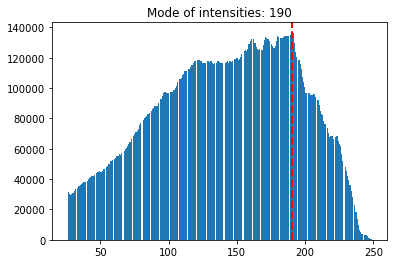

In [151]:
df_sample_Atelectasis = sample_df[sample_df.Atelectasis == 1]

plot_intensities(df_sample_Atelectasis);

### Patients with Edema

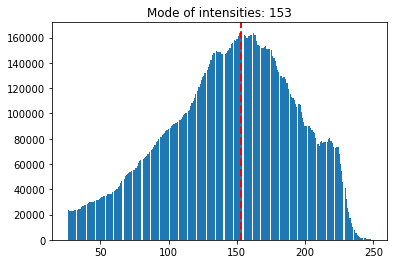

In [130]:
df_sample_Edema = sample_df[sample_df.Edema == 1]

plot_intensities(df_sample_Edema);

### Summary for the intensities EDA:

A histogram of intensities of x-ray images taken from healthy patients has a peak at 191 where a histogram of intensities of x-ray images taken from patients with interested diseases has a peak at the following location:
* Pneumonia: 153
* Infiltration: 145
* Effusion: 214
* Atelectasis: 190
* Edema: 153

Based on this data, we can use the intensities data to classify a healthy patient and a patient with one of the following diseases: Pneumonia, Infiltration, Effusion, and Edema. However, the intensity data won't be suitable for a task to classify a healthy patient and a patient with Atelectasis because the peak values of those histograms are very close.

## Additional Hardware/Software info

In [4]:
!nvidia-smi

Sun Dec 27 16:18:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    70W / 149W |  11045MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import keras; print(keras.__version__)

Using TensorFlow backend.


2.3.1
